In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [3]:
from olist.data import Olist
from olist.order import Order
from olist.seller import Seller


In [6]:
# load data via exisitng package
seller = Seller()
sellers = seller.get_training_data()
sellers['rank'] = sellers['profits'].rank()


# Understanding our Sources of Poor Performance and Losses 
## 1. Negative Externalities of Large Sellers 
### - We are suffreing damage to our reputation caused by sellers who with large quantities of low quality product
### - IT Costs: these sellers are especially costly when considering IT Costs for hosting them and their volumes 
## 2. Remove Underperforming Regions 
### - Ibitinga is costing 50k to sell from, we should pause sales from here   

In [25]:
data = {
    'Metrics': ['Total Profits', 'IT Costs', 'Cost of Reviews', 'Revenues'],
    'Existing Sellers': [667609.0, 499999.0, 1618210.0, 2785818.0,],
    '90 Sellers removed': [1004820.0, 438405.0, 1001370.0, 2444595.0]
}
df = pd.DataFrame(data)

# Remove the Worst 90 Sellers 
## - After 90 the rate of improvement slows significantly
## - We are allowing for some losses, as some sellers may need time to improve 
## - Maintain Scale : There is value in a larger platfrom  

In [53]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import plotly.graph_objects as go


# Assuming 'result' is your DataFrame and it has an index and the columns 'Savings', 'Profit_Improvement', 'Total_Improvement'

# Initialize a figure object
fig = go.Figure()

# Add the first scatter plot for 'Savings'
fig.add_trace(go.Scatter(x=result.index, y=result['Savings'], mode='markers', name='Savings'))

# Add the second scatter plot for 'Profit_Improvement'
fig.add_trace(go.Scatter(x=result.index, y=result['Profit_Improvement'], mode='markers', name='Profit Improvement'))

# Add the third scatter plot for 'Total_Improvement'
fig.add_trace(go.Scatter(x=result.index, y=result['Total_Improvement'], mode='markers', name='Total Improvement'))

# Update the layout if needed, here you can add a title, axis labels, etc.
fig.update_layout(title='Potential Profit Improvement', xaxis_title='Sellers to Remove', yaxis_title='BRL Improvement')

# Show the figure
fig.show()

In [54]:
fig = px.bar(df, x='Metrics', y=['Existing Sellers', '90 Sellers removed'],
             barmode='group',
             labels={'value': 'Value', 'Metrics': 'Metric', 'variable': 'Seller Condition'},
             title='Data with Existing Sellers vs Removed Sellers')
fig.show()

In [55]:
import plotly.express as px
fig = px.scatter(sellers, x='rank', y='profits', color='quantity', size='quantity',hover_name="seller_city",title='Ranked Seller Performance with Quantity')
fig.show()

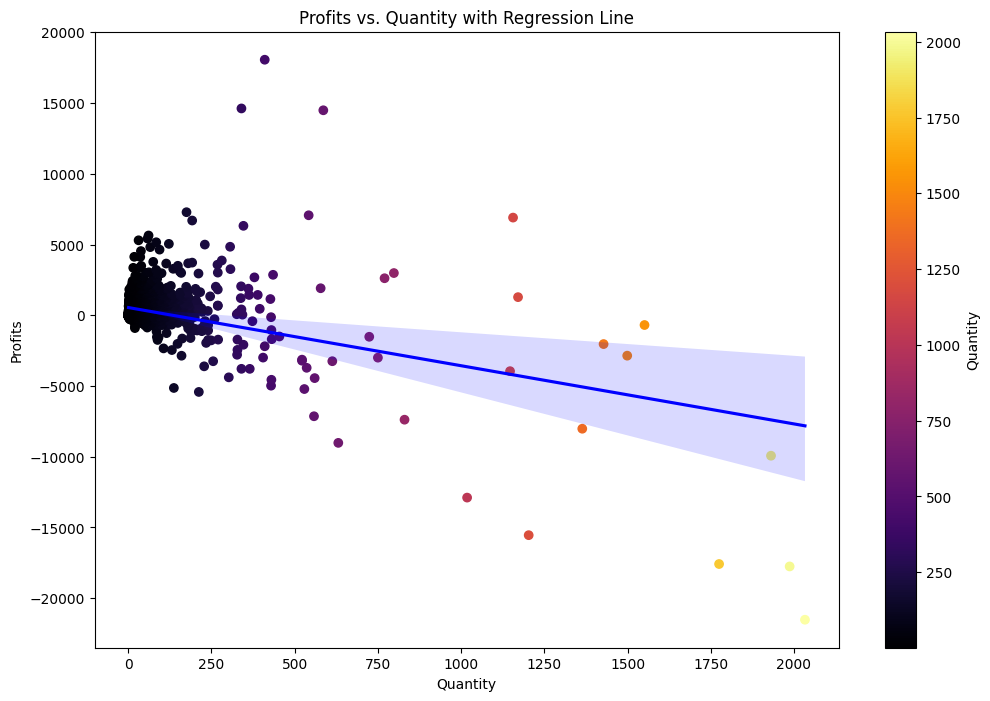

In [56]:
# Total Savings = Profit + IT Cost Saving

# Set figure size
plt.figure(figsize=(12, 8))

# Create a scatter plot with color mapping
# Note: Adjust the 'c' parameter to map colors based on 'quantity'
scatter = plt.scatter('quantity', 'profits', c='quantity', cmap='inferno', data=sellers)

# Add a colorbar
plt.colorbar(scatter, label='Quantity')

# Use seaborn to fit and plot the regression line
sns.regplot(data=sellers, x='quantity', y='profits', scatter=False, color='blue')

# Set the plot title and labels
plt.title('Profits vs. Quantity with Regression Line')
plt.xlabel('Quantity')
plt.ylabel('Profits')

plt.show()
#import plotly.express as px
#fig = px.scatter(sellers, x='quantity', y='profits', color='quantity', size='quantity',hover_name="seller_city",title='Ranked Seller Performance with Quantity')
#fig.show()

In [57]:
fig = px.scatter(sellers, x='months_on_olist', y='profits', color='quantity', size='cost_of_reviews',\
                 title='Performance By Seller, Considering Months on Olist')
fig.show()


In [30]:
def get_max_profit_list(n):
    # Initialize lists to store calculations
    savings_list = []
    profit_improvement_list = []
    total_improvement_list = []
    # Calculate values for each i up to n
    for i in range(1, n + 1):
        savings = seller.get_IT_cost_savings(i)
        profit_improvement = seller.get_improved_profits(i)
        total_improvement = savings + profit_improvement
        # Append the calculated values to the respective lists
        savings_list.append(savings)
        profit_improvement_list.append(profit_improvement)
        total_improvement_list.append(total_improvement)
    # Create the DataFrame from the lists
    df = pd.DataFrame({
        'Savings': savings_list,
        'Profit_Improvement': profit_improvement_list,
        'Total_Improvement': total_improvement_list
    })
    # df now has 3 columns ('Savings', 'Profit_Improvement', 'Total_Improvement') and n rows
    return df

result = get_max_profit_list(250)

## Finding Underperforming Regions 


In [19]:

states = \
            sellers\
            .groupby('seller_state',
                     as_index=False).agg({'seller_city':lambda x: list(x.unique()),
                                          'wait_time': 'mean',
                                            'delay_to_carrier': 'mean',
                                            'review_score': 'mean',
                                            'revenues': 'sum',
                                            'cost_of_reviews': 'sum',
                                            'profits': 'sum'
                                            })

cities = \
            sellers\
            .groupby('seller_city',
                     as_index=False).agg({'wait_time': 'mean',
                                            'delay_to_carrier': 'mean',
                                            'review_score': 'mean',
                                            'revenues': 'sum',
                                            'cost_of_reviews': 'sum',
                                            'profits': 'sum'
                                            })


In [ ]:
cities.sort_values(by='profits', ascending=True)

In [58]:
import plotly.express as px


fig = px.scatter(cities, x='wait_time', y='profits', color='seller_city', size='cost_of_reviews',hover_name="seller_city",title='Performance By City')
fig.show()


In [59]:
import plotly.express as px

fig = px.scatter(cities, x='delay_to_carrier', y='profits', color='seller_city', size='cost_of_reviews',hover_name="seller_city",\
                 title='Performance By City, Considering Delay to Carrier')
fig.show()


In [60]:

fig = px.scatter(sellers, y='rank', x='review_score', color='profits', size='quantity',hover_name="seller_state", size_max = 40,
                 title='Check Our Assumptions, Is 3.5 Stars so Bad? ')
fig.show()

# Conclusions
## Removing the worst 90 sellers will optimise P&L
## If we are certain about our assumption of costs of 3 Star reviews
##  - Beware high volume low quality sellers -
## Check what is causing delays from Ibitinga